<a href="https://colab.research.google.com/github/nmningmei/Deep_learning_fMRI_EEG/blob/master/5_6_Extract_CV_representation_of_experiment_stimuli_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# just have to do this if the data is in google drive

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.8MB/s 


# get the data from google drive

In [0]:
image_id = 'https://drive.google.com/open?id=1OUb5x8HMtVzVQqgbLSDnzRS0c9BcDapl'.split('id=')[-1]
downloaded = drive.CreateFile({'id':image_id})
downloaded.GetContentFile(f'metasema_img.zip')

In [0]:
word_id = 'https://drive.google.com/open?id=18nfVy-o0GWX-QKEWrKK0EKLLAltpFy4U'.split('id=')[-1]
downloaded = drive.CreateFile({'id':word_id})
downloaded.GetContentFile(f'word.npy')

## unzip the images

In [0]:
import zipfile
zip_ref = zipfile.ZipFile('metasema_img.zip', 'r')
zip_ref.extractall('img2vec')
zip_ref.close()


In [0]:
import os
import numpy             as np
import pandas            as pd
import tensorflow        as tf
import seaborn           as sns
import keras.backend     as K
from glob                import glob
from PIL                 import Image
from matplotlib          import pyplot as plt
from scipy.spatial       import distance
from tensorflow.keras    import models,layers,regularizers,optimizers,losses,applications
from sklearn.utils       import shuffle

Using TensorFlow backend.


In [0]:
image_dir       = 'img2vec'
words           = np.load('word.npy').astype(str)
images          = glob(os.path.join(image_dir,'*','*','*','*.*'))
image_size      = 128
batch_size      = 16
image_length    = len(images)
IMG_SHAPE       = (image_size, image_size, 3)

label_map       = {'Living_Things':[0,1],
                   'Nonliving_Things':[1,0]}

# define canidate models

In [0]:
cadidates = [applications.VGG19,
             applications.DenseNet121,
             applications.MobileNetV2]

# the full process

W0617 11:57:48.210104 139975661651840 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


9412608/9406464 [==============================] - 0s 0us/step


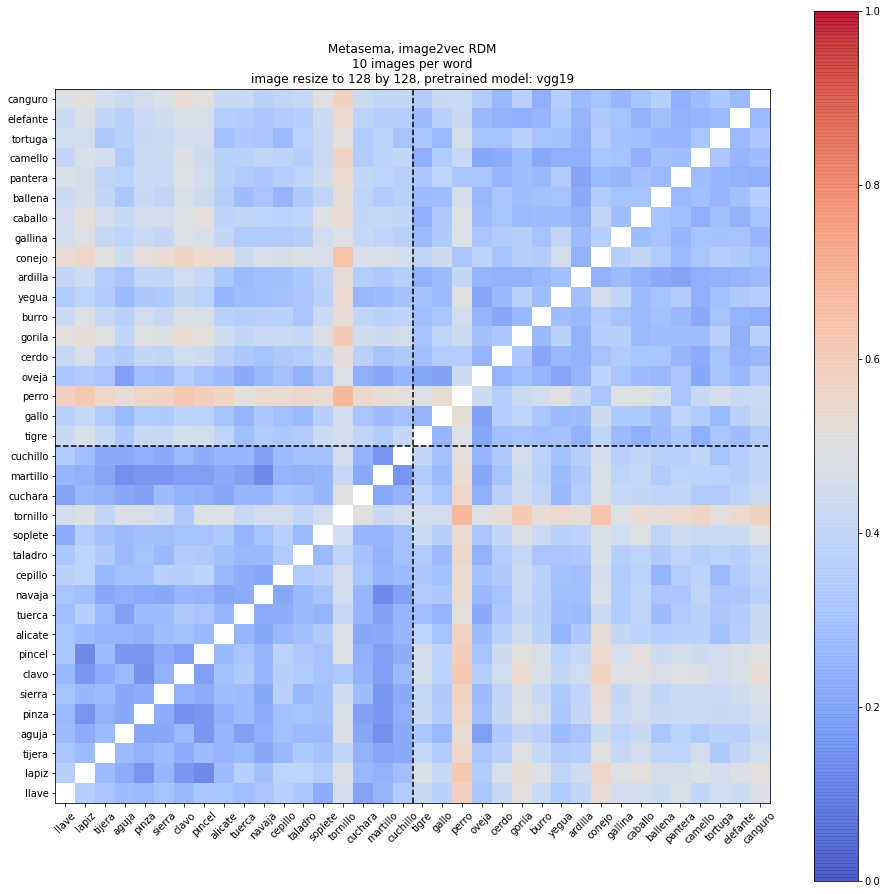

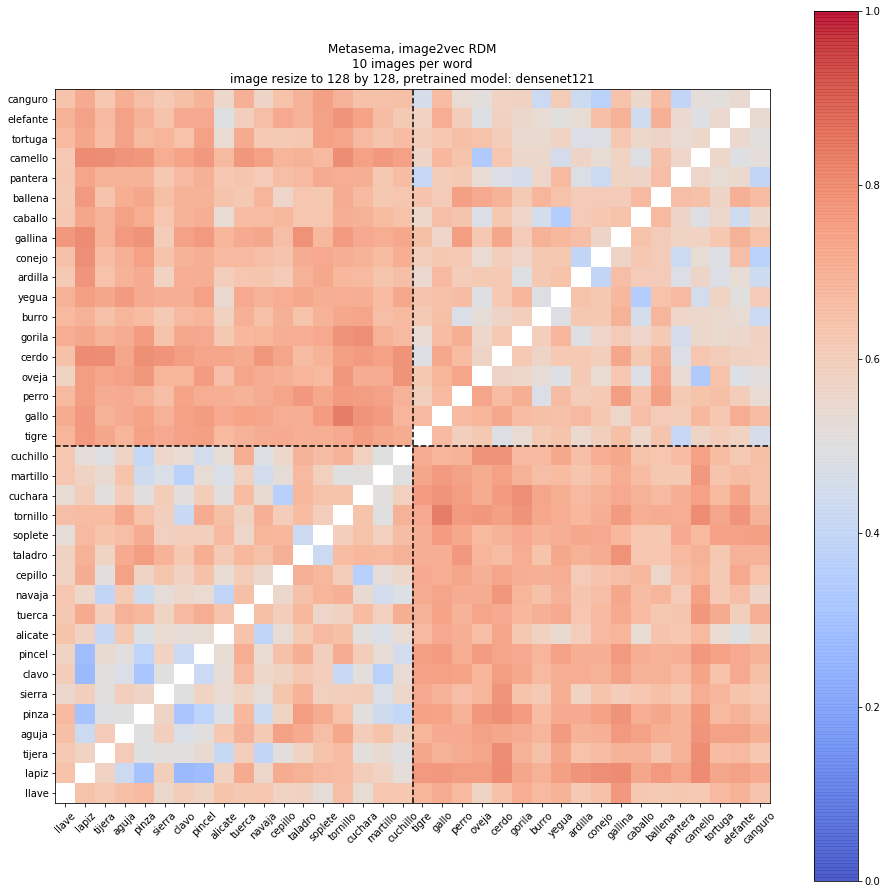

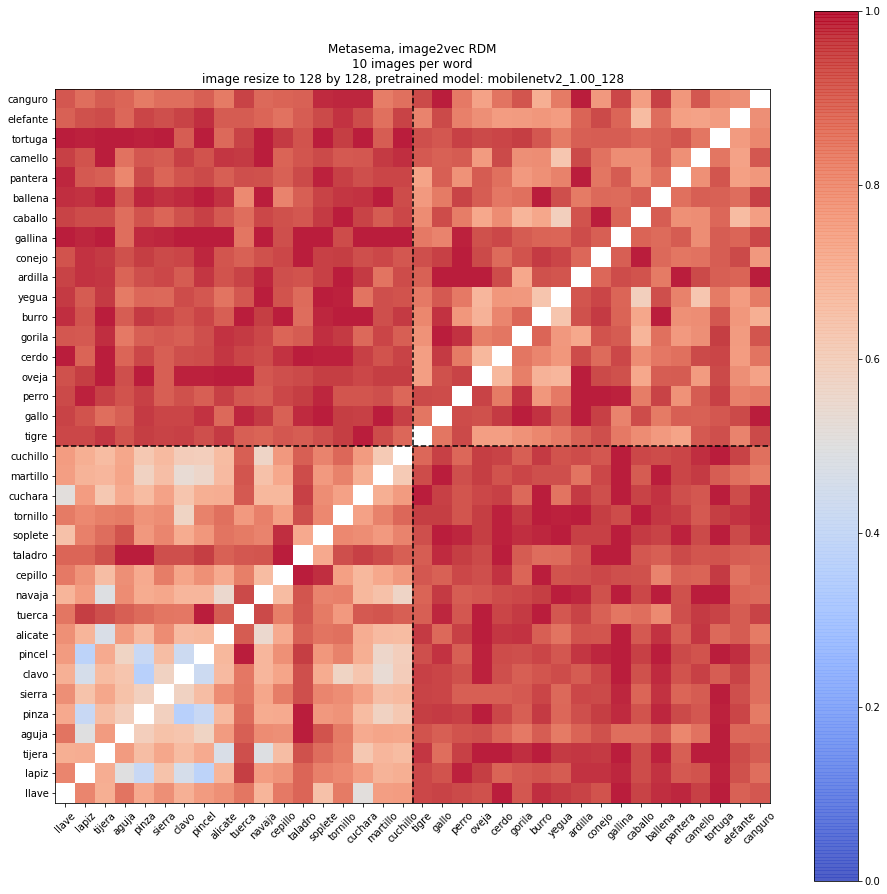

In [0]:
for model_ in cadidates:
    base_model      = model_(
                              weights       = 'imagenet',
                              input_shape   = IMG_SHAPE,
                              include_top   = False,
                              pooling       = 'max')
    base_model.trainable = False
    
    data            = {}
    labels          = []
    for image_dir in images:
        image_name  = image_dir.split('/')[-2]
        if image_name not in list(data.keys()):
            data[image_name.lower()] = []
            labels.append(image_name)
        original    = Image.open(image_dir)
        original    = original.convert("RGB")
        resized     = np.array(original.resize((image_size,image_size),Image.ANTIALIAS))
        resized     = resized / 225.
        pred        = base_model.predict(resized[np.newaxis])
        data[image_name.lower()].append(np.squeeze(pred))
    
    for name in words:
        data[name]  = np.mean(data[name],0)
    
    preds_mean      = np.array([data[name] for name in words])
    
    corr            = distance.squareform(
                            distance.pdist(
                                        preds_mean - preds_mean.mean(1).reshape(-1,1),
                                        metric = 'cosine',))
    np.fill_diagonal(corr,np.nan)
    fig,ax          = plt.subplots(figsize = (16,16))
    im              = ax.imshow(
                                corr,
                                origin  = 'lower',
                                cmap    = plt.cm.coolwarm,
                                vmin    = 0,
                                vmax    = 1.,
                                alpha   = 0.9,
                                )
    ax.set(xticks   = np.arange(36),
           yticks   = np.arange(36),
           title    = f'Metasema, image2vec RDM\n10 images per word\nimage resize to {image_size} by {image_size}, pretrained model: {base_model.name}')
    ax.set_xticklabels(words,rotation = 45)
    ax.set_yticklabels(words)
    ax.axhline(35/2,linestyle='--',alpha=1.,color='black')
    ax.axvline(35/2,linestyle='--',alpha=1.,color='black')
    plt.colorbar(im)